# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "update"



In [106]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import pyplot

# TS
from statsmodels.tsa.seasonal import seasonal_decompose

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

'/Users/nilsfulde/Desktop/Master_Thesis/scripts'

## Load Stations

In [107]:
# This bit to define the data that is to be loaded
import glob

# Define the directory path where the CSV files are located
input_path = r'../data/promice/preprocessed/South_West/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'
#staion_list = ['SCO_L.csv','KAN_L.csv']

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

df = df.reset_index(drop=True)

df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

In [108]:
df = df[df['stid'] != 'NUK_U']
df = df[df['stid'] != 'QAS_U']

## melt onset day / melt end day detection

In [109]:
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")
df['Year'] = df['Datetime'].dt.year
df['DayOfYear'] = df['Datetime'].dt.dayofyear

# Initialize new columns with default values
df['first_melt_day'] = False
df['last_melt_day'] = False

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    unique_years = df_station['Year'].unique()
    for year in unique_years:
        # Filter data for the current year
        year_data = df_station[df_station['Year'] == year]

        # Find the first and last melt day
        first_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].min()
        last_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].max()

        # Update the original DataFrame
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == first_melt_day), 'first_melt_day'] = True
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == last_melt_day), 'last_melt_day'] = True

## Time Series Decomposition

In [110]:
# https://datastud.dev/posts/python-seasonality-how-to

In [111]:
# This bit to decompose for each station
for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    if len(df_station) > 730: 
        exec(f"result_{i} = seasonal_decompose(df_station['Surface height from combined measurements'], model='additive', period=365)")
    else:
        print("Station to remove:", i)
        

In [112]:
# This bit to add decomposition to df and smooth the residual component
ts = pd.DataFrame()

for i in df["stid"].unique().tolist():
    
    # Get data frame for the current station
    df_station = df[df['stid'] == i]

    df_station['observed'] = eval(f"result_{i}.observed")
    df_station['residual'] = eval(f"result_{i}.resid") 
    df_station['seasonal'] = eval(f"result_{i}.seasonal") 
    df_station['trend'] = eval(f"result_{i}.trend")
    df_station['residual_smoothed'] = eval(f"result_{i}.resid") 
    
    # Set the window size and threshold
    window_size = 7
    
    #Outliers based on incremental sum
    threshold_incremental_sum = df_station['residual'].diff().rolling(window_size).sum().quantile(0.8)
    threshold_slope = df_station['residual_smoothed'].diff().abs().quantile(0.8)
        # Calculate the sum of incremental changes over the rolling window
    incremental_sum = df_station['residual'].diff().rolling(window_size).sum()
        # Replace the residuals that exceed the threshold with NaN
    df_station['residual_smoothed'] = df_station['residual']
    df_station.loc[incremental_sum > threshold_incremental_sum, 'residual_smoothed'] = np.nan

    # Outliers based on slope
    slope = df_station['residual_smoothed'].diff().abs()
        # Calculate the 80th percentile of the slopes
    threshold_slope = slope.quantile(0.8)
        # Remove values where the slope is steeper than the threshold
    df_station.loc[slope > threshold_slope, 'residual_smoothed'] = np.nan

    # fill in the NaN values with linear interpolation
    #df_station['residual_smoothed'].interpolate(method='linear', inplace=True)

    # Add new column for seasonal residual
    df_station['seasonal_residual'] = df_station['residual_smoothed'].fillna(0) + df_station['seasonal']
    
    # Add column for current station
    df_station['stid'] = i
    
    # Append to time series data frame
    ts = ts.append(df_station[['Datetime', 'stid', 'observed', 'residual', 'seasonal', 'trend', 'residual_smoothed', 'seasonal_residual']])

# Merge time series data frame with original data frame
df = pd.merge(df, ts, on=['Datetime', 'stid'], how='left')


In [113]:
# This bit to generate the periods that we want to focus on
df['seasonal'] = df['seasonal'].astype(float)
# create a new column to store the periods
df['Periods'] = ''

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    # iterate over each year in the dataframe
    for year in df_station['Datetime'].dt.year.unique():
        year_data = df_station[df_station['Datetime'].dt.year == year]
        if len(year_data.index) > 300:
            max_index = year_data['seasonal'].idxmax()
            min_index = year_data['seasonal'].idxmin()

            # set the periods in the new column for the maximum value
            df.loc[max_index-5:max_index, 'Periods'] = 'pre_max'
            df.loc[max_index:max_index+6, 'Periods'] = 'post_max'

            # set the periods in the new column for the minimum value
            df.loc[min_index-5:min_index, 'Periods'] = 'pre_min'
            df.loc[min_index:min_index+6, 'Periods'] = 'post_min'
        else:
            continue 

In [114]:
def mround(x, m=5):
    '''Helper method for multiple round'''
    return int(m * round(float(x)/m))

def plot_components(df, station):
    """Plot data for initial visualization
    Args:
        df (pandas dataframe)
    """
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = mround(np.min([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual ]),5)
    ymax = mround(np.max([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual]),5)
    ymin -= 5
    ymax += 5

    plt.figure(figsize=(20,20))

    #plt.subplot(4,1,1)
    #plt.title("Original Data")
    #plt.ylim(ymin, ymax)
    #plt.plot(df.index, df.observed)

    plt.subplot(4,1,1)
    plt.title("Trend")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.trend)

    plt.subplot(4,1,2)
    plt.title("Seasonal")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.seasonal)

    plt.subplot(4,1,3)
    plt.title("Residual")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual)
    
    plt.subplot(4,1,4)
    plt.title("residual_smoothed")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual_smoothed)

    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    

In [115]:
df["stid"].unique().tolist()

['QAS_L', 'NUK_L', 'KAN_L']

In [116]:
def plt_seasonal_residual(df,station):
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = np.round(np.min([df_axis.seasonal_residual]), 5) - 5
    ymax = np.round(np.max([df_axis.seasonal_residual]), 5) + 5

    plt.figure(figsize=(20,15))

    # Plot the seasonal_residual values
    plt.subplot(4,1,4)
    plt.title("seasonal_residual")
    plt.ylim(ymin, ymax)

    # Plot the pre_max values
    pre_max_indices = df[df['Periods'] == 'pre_max'].index
    plt.scatter(pre_max_indices, df.loc[pre_max_indices, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=20 )

    # Plot the post_max values
    post_max_indices = df[df['Periods'] == 'post_max'].index
    plt.scatter(post_max_indices, df.loc[post_max_indices, 'seasonal_residual'], c='g', marker='.', label='post_max',s=8)

    # Plot the pre_min values
    pre_min_indices = df[df['Periods'] == 'pre_min'].index
    plt.scatter(pre_min_indices, df.loc[pre_min_indices, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=8)

    # Plot the post_min values
    post_min_indices = df[df['Periods'] == 'post_min'].index
    plt.scatter(post_min_indices, df.loc[post_min_indices, 'seasonal_residual'], c='g', marker='.', label='post_min',s=8)

    plt.plot(df.index, df.seasonal_residual, c = "grey")

#plt_seasonal_residual(df,"QAS_L")


In [117]:
#plot_components(df, 'QAS_U')

## Regression Analysis

##### Set target variable

In [118]:
y = 'seasonal_residual'

##### Pre-processing (0.1: Change months to cycle)

In [119]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

#Drop the datetime column
#df.drop(columns=['Datetime'], inplace=True)

In [120]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
df_wind = df[df['Wind from direction (upper boom)'].notna()] 
cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']]) 
df = pd.merge(df, cyclical_df, left_index=True, right_index=True)

# Exclude not needed columns in exclude list
cyclical_df_time = cyclical.fit_transform(df[['month',  'day']]) 

df = pd.merge(df, cyclical_df_time, left_index=True, right_index=True)

##### Pre-processing (1.0: Filter relevant periods)

In [121]:
#df =  df[df['Melting Season'].isin(['pre', 'beginning', 'middle', 'end'])]

#df =  df[df['Ablation'].isin([True])]

In [122]:
df = df[df[y].notna()] 

In [123]:
#df = df.reset_index(drop=True)

In [124]:
# This bit retrieve the indexes for all melting season categories and remove column from df
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('no_ablation')

for category in ['pre', 'beginning', 'middle', 'end', 'no_ablation']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

for category in ['pre_max', 'post_max', 'pre_min', 'post_min']:
    exec(f"indices_{category} = df[df['Periods'] == '{category}'].index")
    
for category in [True]:
    exec(f"indices_first_melt_day= df[df['first_melt_day'] == {category}].index")
for category in [True]:
    exec(f"indices_last_melt_day= df[df['last_melt_day'] == {category}].index")
  

In [125]:
# Convert your Datetime column to datetime objects if not already
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Extract year from the Datetime column
df['year'] = df['Datetime'].dt.year

start_day_first = 10
end_day_first = 10
start_day_last = 10
end_day_last = 10

# Define a custom function to filter rows based on the conditions
def filter_melt_days(group):
    first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
    last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

    start_date = first_melt_day - pd.Timedelta(days=start_day_first)
    end_date = last_melt_day + pd.Timedelta(days=end_day_last)

    return group[(group['Datetime'] >= start_date) & (group['Datetime'] <= end_date)]

# Apply the custom function to each group of 'stid' and 'year' and concatenate the results
df = df.groupby(['stid', 'year']).apply(filter_melt_days).reset_index(drop=True)

for category in [True]:
    exec(f"indices_first_melt_day= df[df['first_melt_day'] == {category}].index")
for category in [True]:
    exec(f"indices_last_melt_day= df[df['last_melt_day'] == {category}].index")
    
# Define a custom function to extract the expanded indices from the filtered DataFrame
def extract_expanded_indices(filtered_df):
    expanded_indices_first = []
    expanded_indices_last = []

    for (stid, year), group in filtered_df.groupby(['stid', 'year']):
        first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
        last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

        start_date_first = first_melt_day - pd.Timedelta(days=start_day_first)
        end_date_first = first_melt_day + pd.Timedelta(days=end_day_first)

        start_date_last = last_melt_day - pd.Timedelta(days=start_day_last)
        end_date_last = last_melt_day + pd.Timedelta(days=end_day_last)

        expanded_first = group[(group['Datetime'] >= start_date_first) & (group['Datetime'] <= end_date_first)].index
        expanded_last = group[(group['Datetime'] >= start_date_last) & (group['Datetime'] <= end_date_last)].index

        expanded_indices_first.extend(expanded_first)
        expanded_indices_last.extend(expanded_last)

    return expanded_indices_first, expanded_indices_last

# Extract the expanded indices for first and last melt days
expanded_indices_first, expanded_indices_last = extract_expanded_indices(df)


##### Pre-processing (2.0: Formatting and transformation)

In [126]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['stid'] = le.fit_transform(df['stid'])
station_names = dict(zip(le.classes_, le.transform(le.classes_)))

In [127]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'Wind from direction (upper boom)',
                'Ablation',
                'Melting Season', # We drop melting season later 
                'month',
                'month_sin',
                'month_cos',
                'day', 
                'day_sin',
                'day_cos',
                'hour', 
                'year',
                'year_sin',
                'year_cos'
                'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
                'trend',
                'residual_smoothed',
                'Periods',
                'Year',
                'first_melt_day',
                'last_melt_day',
                'DayOfYear',
                'Datetime',
                #'seasonal_residual'
               ]


data = df.copy()
df = df[[column for column in df.columns if column not in exclude_list]]


In [128]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Exclude whater is not needed for scaling
exlude_num = ['stid', 
              'Surface height from combined measurements', 
              'Surface height from combined measurements DELTA',
              'month_sin',
              'month_cos',
              'month',
              'day', 
              'day_sin',
              'day_cos',
              'hour', 
              'year',
              'year_sin',
              'year_cos'
              'subgroup',
              'Surface height from combined measurements',
              'Surface height from combined measurements DELTA',
              'observed', 
              'residual', 
              'seasonal', 
              'trend',
              'Wind from direction (upper boom)',
              'Wind from direction (upper boom)_sin',
              'Wind from direction (upper boom)_cos',
              'seasonal_residual',
              'residual_smoothed',
              'Datetime',
             ]


num_cols = df.select_dtypes(include=['int64','float64'])
num_cols = num_cols[[column for column in num_cols.columns if column not in exlude_num]].columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])
data[num_cols] = scaler.fit_transform(data[num_cols])

In [129]:
from sklearn.model_selection import train_test_split

# Get unique stid values
stid_values = df['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df = df[df['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df.drop([y], axis=1), subset_df[y], test_size=0.3, random_state=2023, shuffle =False)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

In [130]:
X_train.columns

Index(['stid', 'Air pressure (upper boom)', 'Air temperature (upper boom)',
       'Relative humidity (upper boom) - corrected',
       'Specific humidity (upper boom)', 'Wind speed (upper boom)',
       'Downwelling shortwave radiation - corrected',
       'Upwelling shortwave radiation - corrected',
       'Downwelling longwave radiation', 'Upwelling longwave radiation',
       'Surface temperature', 'Latent heat flux (upper boom)',
       'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover',
       'Wind from direction (upper boom)_sin',
       'Wind from direction (upper boom)_cos'],
      dtype='object')

## Regression Modelling

In [85]:
#from lazypredict.Supervised import LazyRegressor

#reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
#models,predictions = reg.fit(X_train, X_test, y_train, y_test)
#models

-------

## Selected Models

In [131]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting  # Required to enable HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import numpy as np

In [132]:
# Import required libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import lightgbm as lgb

cv = ShuffleSplit(n_splits=8, test_size=0.3, random_state=42)


Fitting 8 folds for each of 27000 candidates, totalling 216000 fits
Best hyperparameters_seasonal_residual:  {'learning_rate': 0.1, 'max_depth': 13, 'min_child_samples': 10, 'num_leaves': 50, 'reg_alpha': 0.1, 'reg_lambda': 1}
R^2 score on test set (seasonal_residual):  0.47513699940729004
MSE on test set (seasonal_residual):  0.013919788129758751
KAN_L 0
R^2 score on test set (seasonal_residual):  0.29238983459198364
RMSE on test set (seasonal_residual):  0.1504989803827302


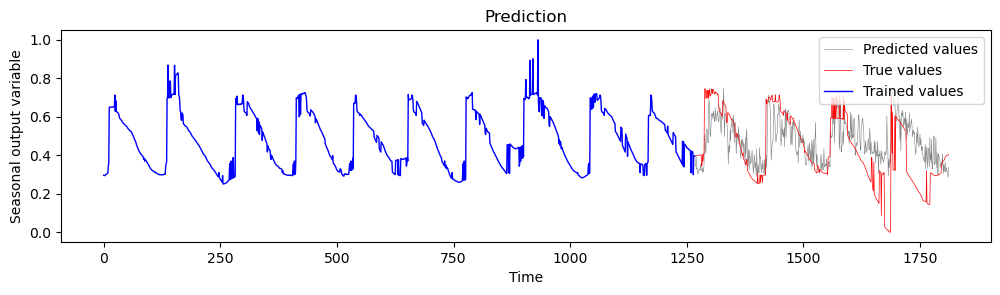

NUK_L 1
R^2 score on test set (seasonal_residual):  0.5689416002598567
RMSE on test set (seasonal_residual):  0.11925675941108131


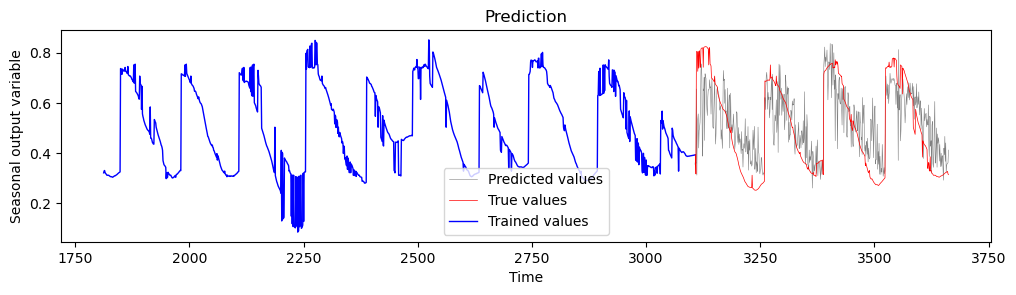

NUK_U 2
R^2 score on test set (seasonal_residual):  -0.4263084438163409
RMSE on test set (seasonal_residual):  0.060514717391491904


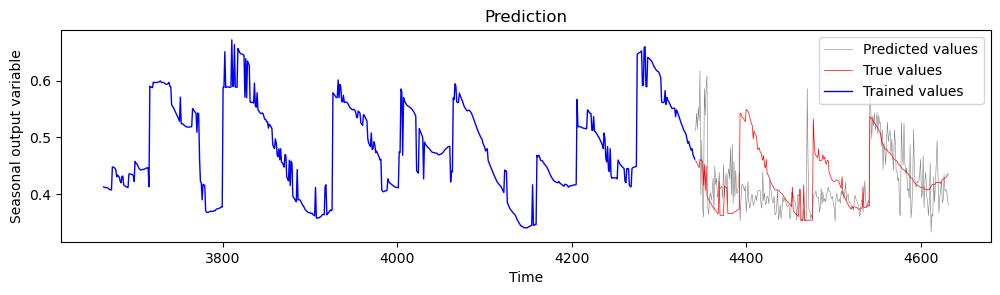

QAS_L 3
R^2 score on test set (seasonal_residual):  0.5356210987370926
RMSE on test set (seasonal_residual):  0.11324201010235632


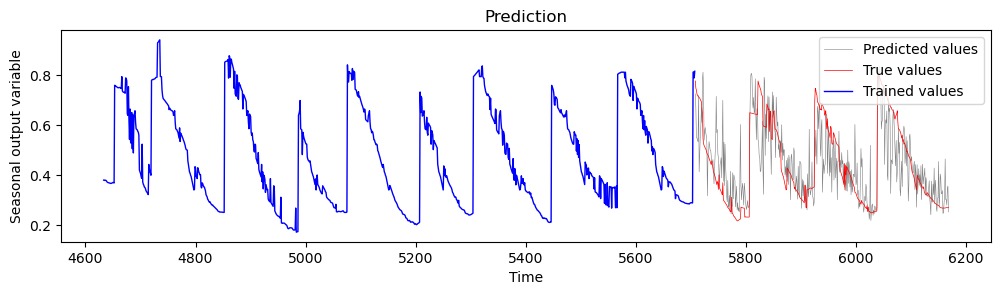

QAS_U 4
R^2 score on test set (seasonal_residual):  -0.6909254005570531
RMSE on test set (seasonal_residual):  0.07530560905545083


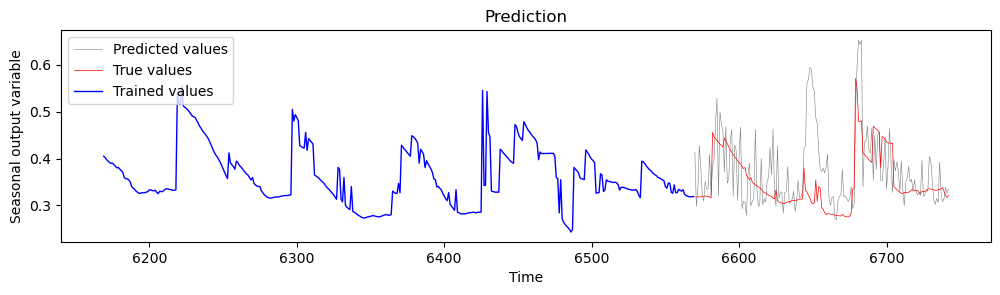

In [35]:
# Light GBM

# Define the hyperparameter grid for tuning
#lgbm_params = {
#    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
#    'num_leaves': [20, 31, 50, 70, 100, 150],
#    'max_depth': [5, 7, 9, 11, 13, 15],
#    'min_child_samples': [10, 20, 30, 50, 80, 100],
#    'reg_alpha': [0, 0.1, 0.5, 1, 2],
#    'reg_lambda': [0, 0.1, 0.5, 1, 2]
#}


# Best parameters

param_grid = {
'learning_rate': 0.1, 'max_depth': 13, 'min_child_samples': 10, 'num_leaves': 50, 'reg_alpha': 0.1, 'reg_lambda': 1

}


# Define the LightGBM regressor model
model = lgb.LGBMRegressor()

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)


# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)

# Save the best model parameters as 'model' variable
exec(f"gbm_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"gbm_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R^2 score on test set ({y}): ", r2)
print(f"MSE on test set ({y}): ", mse)

for value, station_name in enumerate(station_names):
    print(station_name, value)

    plt.figure(figsize=(10,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"gbm_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=False)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"RMSE on test set ({y}): ", mse_station)

    # Plot the seasonal output variable, trained values, tested values, and predicted values
    plt.plot(y_test_station.index, y_pred_station, label= 'Predicted values', color='grey', linewidth=0.4)
    plt.plot(y_test_station.index, y_test_station, label='True values', color='red', linewidth=0.5)
    plt.plot(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    
    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()


In [53]:
# XGB Regressor
model = xgb.XGBRegressor()

# Define the hyperparameter grid for tuning
#xgb_params = {
#    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
#    'max_depth': [5, 7, 9, 11, 13, 15],
#    'min_child_weight': [1, 2, 4, 6, 8, 10], 
#    'gamma': [0, 0.1, 0.5, 0.7, 1], 
#    'subsample': [0.5, 0.7, 0.8, 0.9, 1], 
#    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
#}

#Old params 

param_grid = {
'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.8
}


# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)

# Save the best model parameters as 'model' variable
exec(f"xgb_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"xgb_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
print(f"R^2 score on test set ({y}): ", r2)
print(f"MSE on test set ({y}): ", mse)

for value, station_name in enumerate(station_names):
    print(station_name, value)

    plt.figure(figsize=(10,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"xgb_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=False)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"RMSE on test set ({y}): ", mse_station)

    # Plot the seasonal output variable, trained values, tested values, and predicted values
    plt.plot(y_test_station.index, y_pred_station, label= 'Predicted values', color='grey', linewidth=0.4)
    plt.plot(y_test_station.index, y_test_station, label='True values', color='red', linewidth=0.5)
    plt.plot(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    
    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()


TypeError: Parameter grid for parameter 'colsample_bytree' needs to be a list or a numpy array, but got 0.9 (of type float) instead. Single values need to be wrapped in a list with one element.

Fitting 8 folds for each of 1 candidates, totalling 8 fits
Overall R^2 score on test set (seasonal_residual):  0.4978887972021846
Overall RMSE on test set (seasonal_residual):  0.9543846510526632
KAN_L
R^2 score on test set (seasonal_residual):  0.3157643768562859
RMSE on test set (seasonal_residual):  1.1533812385914384


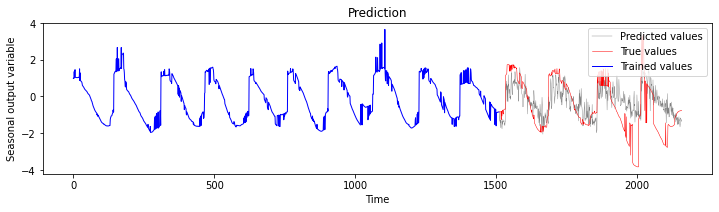

NUK_L
R^2 score on test set (seasonal_residual):  0.6022714291955238
RMSE on test set (seasonal_residual):  0.8305062688557423


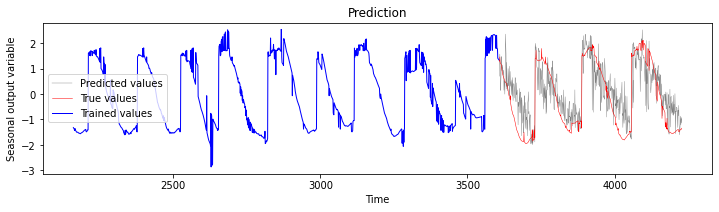

QAS_L
R^2 score on test set (seasonal_residual):  0.5963015882031897
RMSE on test set (seasonal_residual):  0.8133173169263377


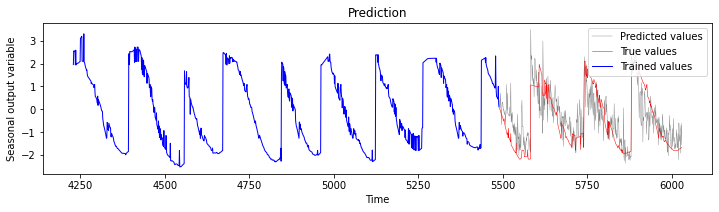

In [133]:
# This bit to find best HistGradientBoostingRegressor model for when Ablation == True and for both target variables
model = HistGradientBoostingRegressor()

# Define the hyperparameter grid for tuning
#hgb_params = {
#    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
#    'max_iter': [100, 200, 300, 400, 500],
#    'max_depth': [5, 7, 9, 11, 13, 15],
#    'min_samples_leaf': [10, 20, 30, 50, 80, 100],
#    'max_leaf_nodes': [20, 31, 50, 70, 100, 150],
#    'l2_regularization': [0, 0.1, 0.5]
#}

#Old params

param_grid = {
    'max_depth': [3],#[3, 5, 7],
    'min_samples_leaf': [1],#[1, 3, 5],
    'learning_rate': [0.1],#[0.1, 0.01, 0.001],
    'max_iter': [100],#[100, 500, 1000],
    'l2_regularization': [0.5],#[0, 0.1, 0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set

# Save the best model parameters as 'model' variable
exec(f"hist_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"hist_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Overall R^2 score on test set ({y}): ", r2)
print(f"Overall RMSE on test set ({y}): ", mse)

for value, station_name in enumerate(station_names):
    print(station_name)

    plt.figure(figsize=(10,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"hist_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=False)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"RMSE on test set ({y}): ", mse_station)

    # Plot the seasonal output variable, trained values, tested values, and predicted values
    plt.plot(y_test_station.index, y_pred_station, label= 'Predicted values', color='grey', linewidth=0.4)
    plt.plot(y_test_station.index, y_test_station, label='True values', color='red', linewidth=0.5)
    plt.plot(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    
    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()


In [134]:
X_train.columns.to_list()

['stid',
 'Air pressure (upper boom)',
 'Air temperature (upper boom)',
 'Relative humidity (upper boom) - corrected',
 'Specific humidity (upper boom)',
 'Wind speed (upper boom)',
 'Downwelling shortwave radiation - corrected',
 'Upwelling shortwave radiation - corrected',
 'Downwelling longwave radiation',
 'Upwelling longwave radiation',
 'Surface temperature',
 'Latent heat flux (upper boom)',
 'Sensible heat flux (upper boom)',
 'Albedo',
 'Cloud cover',
 'Wind from direction (upper boom)_sin',
 'Wind from direction (upper boom)_cos']

## Filter by Melting Season and get feature importances 

In [135]:
import shap

explainer = eval(f"shap.Explainer(hist_model_{y})")

###### First Melt Day

In [136]:
X_set = pd.concat([X_train, X_test])
y_set = pd.concat([y_train, y_test])

index_filter_first_melt_day = indices_first_melt_day.to_list()

shap_values = explainer(X_set.loc[index_filter_first_melt_day])
mean_abs_shap_values = shap_values.abs.mean(0)

X = X_set.loc[index_filter_first_melt_day]
y = y_set[index_filter_first_melt_day]

positive_color = "#ca0020"
negative_color = "#92c5de"

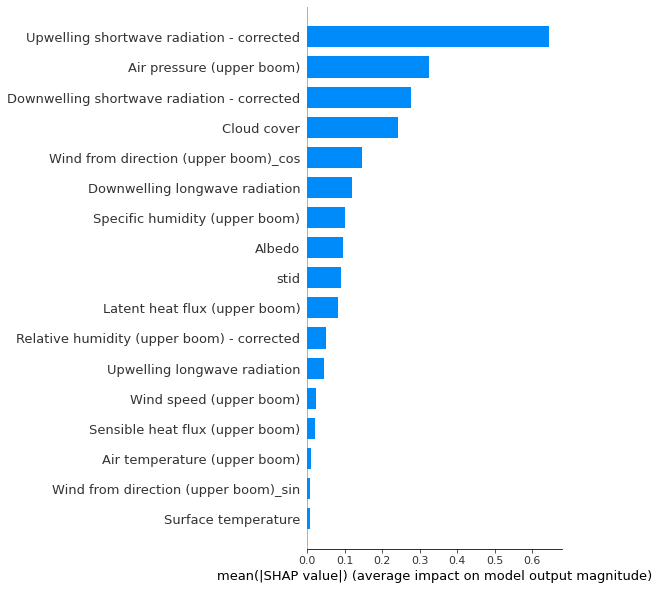

In [137]:
# Plot the SHAP summary plot using the shap.summary_plot() function for the subset of interest
shap.summary_plot(shap_values, X.loc[index_filter_first_melt_day], plot_type='bar')

Top 5 Shapley values for the beginning of melting seasons


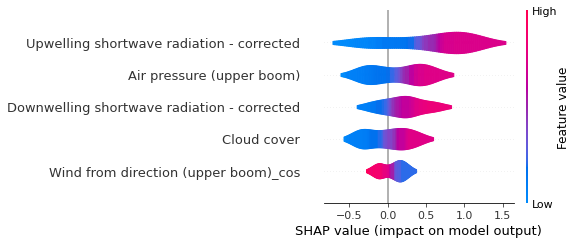

In [138]:
print("Top 5 Shapley values for the beginning of melting seasons")
shap.summary_plot(shap_values, X.loc[index_filter_first_melt_day], max_display=5,plot_type="violin")

In [139]:
# Average SHAP values for the filtered indices
avg_shap_values = np.mean(shap_values.values, axis=0)

# Create a single-row DataFrame containing the average SHAP values
avg_shap_df = pd.DataFrame([avg_shap_values], columns=X.columns)

# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values=avg_shap_df.values,
    base_values= explainer.expected_value,
    data=X.loc[index_filter_first_melt_day].mean(axis=0).values.reshape(1, -1),
    feature_names=X.columns,
)

shap.initjs()
shap.force_plot(avg_explanation, matplotlib=False, plot_cmap = [positive_color, negative_color])

In [157]:
shap.initjs()

positive_color = "#ca0020"
negative_color = "#92c5de"

shap.force_plot(explainer.expected_value, shap_values.values, X.loc[index_filter_first_melt_day], plot_cmap = [positive_color, negative_color])  


KeyError: '[154, 321, 476, 634, 771, 915, 1076, 1238, 1383, 1545, 1697, 1870, 2027, 2165, 2222, 2389, 2536, 2665, 2832, 2998, 3126, 3297, 3470, 3570, 3740, 3899, 4068, 4239, 4403, 4568, 4682, 4855, 4972, 5134, 5274, 5447, 5593, 5751, 5891] not in index'

In [155]:
clustering = shap.utils.hclust(X, y)
# Use mean absolute SHAP values for the bar plot
shap.plots.bar(mean_abs_shap_values, clustering=clustering)

ValueError: Found input variables with inconsistent numbers of samples: [21, 840]

AssertionError: 'shap_values' and 'features' values must have the same number of rows!

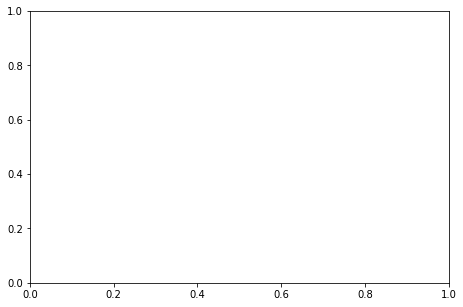

In [156]:
#shap.plots.partial_dependence("Albedo", eval(f"hist_model_{y}").predict, X, ice=False, model_expected_value=True, feature_expected_value=True)

shap_values_array = shap_values.values

shap.dependence_plot('Albedo', shap_values_array, X)

In [146]:
filter = expanded_indices_first

columns_to_remove = ["seasonal_residual"]
X_set= df[[col for col in df.columns if col not in columns_to_remove]]
y_set = df["seasonal_residual"]
#X_set = pd.concat([X_train, X_test])
#y_set = pd.concat([y_train, y_test])
y = y_set[filter]
shap_values = explainer(X_set)

## This bit to check credibility by R^2
y_pred = hist_model_seasonal_residual.predict(X_set.loc[filter])
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred, squared=False)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

## This bit to calculate the average X entries for -10/+10 days across all stations and years
#Filter by indices
X = X_set.loc[filter]
# Merge date to group by year 
X = pd.merge(X, data[['Datetime', 'Ablation']], left_index=True, right_index=True)
X['Year'] = X['Datetime'].dt.year
# Add predictions to be used in base values calculations
predictions = hist_model_seasonal_residual.predict(X.iloc[:,:17])
X['predicted'] = predictions
X_temp = X
# Create a new column 'EntryNumber' to store the entry number for each year
X['EntryNumber'] = X.groupby(['stid', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
X = X.groupby('EntryNumber').mean().reset_index()
columns_to_remove = ['EntryNumber', 'Ablation', 'Year', 'predicted','stid_y']
X = X[[col for col in X.columns if col not in columns_to_remove]]

## This bit to calculate the average SHap values for -10/+10 days across all stations and years
avg_shap_df = pd.merge(pd.DataFrame(shap_values.values, columns= X.columns).loc[filter], data[['Datetime', "stid"]], left_index=True, right_index=True)
avg_shap_df['Datetime'] = pd.to_datetime(avg_shap_df['Datetime'])
# Extract the year from the DateTime column and create a new column 'Year'
avg_shap_df['Year'] = avg_shap_df['Datetime'].dt.year
# Create a new column 'EntryNumber' to store the entry number for each year
avg_shap_df['EntryNumber'] = avg_shap_df.groupby(['stid_y', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
avg_shap_df = avg_shap_df.groupby('EntryNumber').mean().reset_index()
# Drop unnecessary columns from the result
avg_shap_df = avg_shap_df[[col for col in avg_shap_df.columns if col not in columns_to_remove]]
avg_shap_df = avg_shap_df.reset_index(drop=True)

## This bit to calculate the base value (prediction of first row - sum of shap values for this day)
base = predictions[0] - np.sum(pd.DataFrame(avg_shap_df.values).iloc[0:1,:17], axis=1) 




# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values = avg_shap_df.values,
    base_values =  base[0], #base,#np.mean(xgb_model_seasonal_residual.predict(X_set.loc[filter])), #explainer.expected_value,
    data = X, #X.loc[filter].mean(axis=0).values.reshape(1, -1),
    feature_names = X.columns
)

shap.initjs()

positive_color = "#ca0020"
negative_color = "#92c5de"

key = [-x for x in range(start_day_first, 0, -1)] + list(range(end_day_first + 1))

force_plot = shap.force_plot(avg_explanation, X, plot_cmap = [positive_color, negative_color], ordering_keys=key)
shap.save_html(r'../figures/SW/Results/SW_first_10.html', force_plot)

force_plot

R^2 score on test set:  -0.5599073477065357
MSE on test set:  0.8639431349182165


###### Last Melt Day

In [147]:
X_set = pd.concat([X_train, X_test])
y_set = pd.concat([y_train, y_test])

index_filter_last_melt_day = indices_last_melt_day.to_list()

shap_values = explainer(X_set.loc[index_filter_last_melt_day])
mean_abs_shap_values = shap_values.abs.mean(0)
X = X_set.loc[index_filter_last_melt_day]
y = y_set[index_filter_last_melt_day]

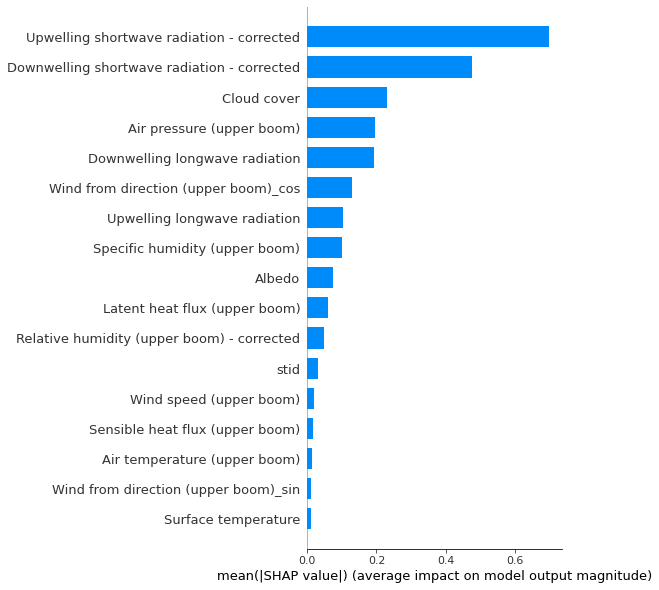

In [148]:
# Plot the SHAP summary plot using the shap.summary_plot() function for the subset of interest
shap.summary_plot(shap_values, X.loc[index_filter_last_melt_day], plot_type='bar')

Top 5 Shapley values for the beginning of melting seasons


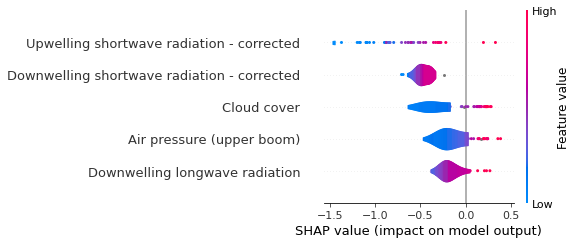

In [149]:
print("Top 5 Shapley values for the beginning of melting seasons")
shap.summary_plot(shap_values, X.loc[index_filter_last_melt_day], max_display=5 , plot_type="violin")

In [150]:
# Average SHAP values for the filtered indices
avg_shap_values = np.mean(shap_values.values, axis=0)

# Create a single-row DataFrame containing the average SHAP values
avg_shap_df = pd.DataFrame([avg_shap_values], columns=X.columns)

# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values=avg_shap_df.values,
    base_values=explainer.expected_value,
    data=X.loc[index_filter_last_melt_day].mean(axis=0).values.reshape(1, -1),
    feature_names=X.columns,
)

positive_color = "#ca0020"
negative_color = "#92c5de"

shap.initjs()
shap.force_plot(avg_explanation, matplotlib=False, plot_cmap = [positive_color, negative_color])

In [151]:
shap.initjs()
positive_color = "#ca0020"
negative_color = "#92c5de"
shap.force_plot(explainer.expected_value, shap_values.values, X.loc[index_filter_last_melt_day], plot_cmap = [positive_color, negative_color])



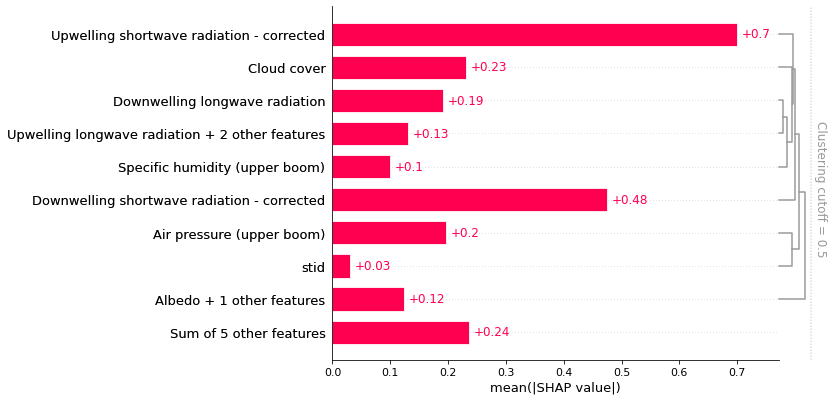

In [152]:
clustering = shap.utils.hclust(X, y)
# Use mean absolute SHAP values for the bar plot
shap.plots.bar(mean_abs_shap_values, clustering=clustering)

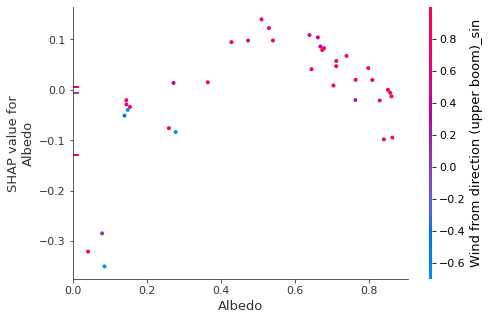

In [153]:
#shap.plots.partial_dependence("Albedo", eval(f"hist_model_{y}").predict, X, ice=False, model_expected_value=True, feature_expected_value=True)

shap_values_array = shap_values.values

shap.dependence_plot('Albedo', shap_values_array, X)



In [154]:
filter = expanded_indices_last

columns_to_remove = ["seasonal_residual"]
X_set= df[[col for col in df.columns if col not in columns_to_remove]]
y_set = df["seasonal_residual"]

y = y_set[filter]
shap_values = explainer(X_set)

## This bit to check credibility by R^2
y_pred = hist_model_seasonal_residual.predict(X_set.loc[filter])
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred, squared=False)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

## This bit to calculate the average X entries for -10/+10 days across all stations and years
#Filter by indices
X = X_set.loc[filter]
# Merge date to group by year 
X = pd.merge(X, data[['Datetime', 'Ablation']], left_index=True, right_index=True)
X['Year'] = X['Datetime'].dt.year
# Add predictions to be used in base values calculations
predictions = hist_model_seasonal_residual.predict(X.iloc[:,:17])
X['predicted'] = predictions
X_temp = X
# Create a new column 'EntryNumber' to store the entry number for each year
X['EntryNumber'] = X.groupby(['stid', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
X = X.groupby('EntryNumber').mean().reset_index()
columns_to_remove = ['EntryNumber', 'Ablation', 'Year', 'predicted','stid_y']
X = X[[col for col in X.columns if col not in columns_to_remove]]

## This bit to calculate the average SHap values for -10/+10 days across all stations and years
avg_shap_df = pd.merge(pd.DataFrame(shap_values.values, columns= X.columns).loc[filter], data[['Datetime', "stid"]], left_index=True, right_index=True)
avg_shap_df['Datetime'] = pd.to_datetime(avg_shap_df['Datetime'])
# Extract the year from the DateTime column and create a new column 'Year'
avg_shap_df['Year'] = avg_shap_df['Datetime'].dt.year
# Create a new column 'EntryNumber' to store the entry number for each year
avg_shap_df['EntryNumber'] = avg_shap_df.groupby(['stid_y', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
avg_shap_df = avg_shap_df.groupby('EntryNumber').mean().reset_index()
# Drop unnecessary columns from the result
avg_shap_df = avg_shap_df[[col for col in avg_shap_df.columns if col not in columns_to_remove]]
avg_shap_df = avg_shap_df.reset_index(drop=True)

## This bit to calculate the base value (prediction of first row - sum of shap values for this day)
base = predictions[0] - np.sum(pd.DataFrame(avg_shap_df.values).iloc[0:1,:17], axis=1) 




# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values = avg_shap_df.values,
    base_values =  base[0], #base,#np.mean(xgb_model_seasonal_residual.predict(X_set.loc[filter])), #explainer.expected_value,
    data = X, #X.loc[filter].mean(axis=0).values.reshape(1, -1),
    feature_names = X.columns
)

shap.initjs()

positive_color = "#ca0020"
negative_color = "#92c5de"

key = [-x for x in range(start_day_last, 0, -1)] + list(range(end_day_last + 1))

force_plot = shap.force_plot(avg_explanation, X, plot_cmap = [positive_color, negative_color], ordering_keys=key)

shap.save_html(r'../figures/SW/Results/SW_last_10.html', force_plot)

force_plot

R^2 score on test set:  -0.2845763023763852
MSE on test set:  0.6060324531222606


-------